In [1]:
!pip install tensorflow==2.15.0


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install numpy==1.23.5



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import load_model


import numpy as np

import IPython

Getting the data from dataset for testing and inference

In [4]:
data_dir = r'flickr8k'
image_dir = f'{data_dir}\Images'
txt_file = f'{data_dir}\captions.txt'

full_image_dir = []
s0_comment_s1 = []

with open(txt_file,'r') as file:
  content = file.readlines()
  content = content[1:]
  for line in content:
    result = line.split(',')
    image_name = result[0]
    raw_comment = result[1]
    single_image_full_dir = f'{image_dir}/{image_name}'
    single_comment = f'<start> {raw_comment} <end>'
    single_comment = single_comment.lower()
    single_comment = single_comment.replace("\n","").replace(".","").replace(",","").replace(" a "," ").replace(" the "," ").replace(" an "," ").replace(" is "," ").replace(" are "," ").replace("'s"," ")
    single_comment = single_comment.strip()    
    # single_comment = raw_comment
    full_image_dir.append(single_image_full_dir)
    s0_comment_s1.append(single_comment)


Size = len(full_image_dir)
train_size = int(0.8 * Size)
val_size = int(0.05 * Size)
test_size = int(0.15 * Size)

train_full_image_dir = full_image_dir[:train_size]
val_full_image_dir = full_image_dir[train_size:train_size+val_size]
test_full_image_dir = full_image_dir[train_size+val_size:]


train_s0_comment_s1 = s0_comment_s1[:train_size]
val_s0_comment_s1 = s0_comment_s1[train_size:train_size+val_size]
test_s0_comment_s1 = s0_comment_s1[train_size+val_size:]


train_df = {'image_name':train_full_image_dir,'comment':train_s0_comment_s1}
val_df = {'image_name':val_full_image_dir,'comment':val_s0_comment_s1}
test_df = {'image_name':test_full_image_dir,'comment':test_s0_comment_s1}

In [5]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image

Getting CNN Model ready

In [6]:
def image_scaling(image_path_list,show = True):
    # Load all images into a single numpy array
    print(f'img')
    is_image_data_list = [image.img_to_array(image.load_img(image_path, target_size=(224, 224))) for image_path in image_path_list]
    print('step 1 done')
    is_image_data = np.array(is_image_data_list)
    print('step 2 done')
    # Preprocess all images at once
    is_image_data = preprocess_input(is_image_data)
    print('step 3 done')

    if show == True:
      print(f'img data shape is {is_image_data.shape}')

    return is_image_data

In [7]:
cnn_model = ResNet50(weights='imagenet', include_top=False)
cnn_model.trainable = False

In [8]:
emb_dim = 512

In [9]:
def spatial_representation(image_path_list,show = True):
  # model = EfficientNetB0(weights = 'imagenet',include_top = False)
  # model.trainable = False
  sr_image_array = image_scaling(image_path_list)
  sr_predictions = cnn_model.predict(sr_image_array)
  # sr_flatten_layer = Flatten()(sr_predictions)
  sr_pooling_layer =  GlobalAveragePooling2D()(sr_predictions)
  sr_dense_layer = Dense(emb_dim,activation = 'sigmoid')(sr_pooling_layer)
  # sr_dense_layer = np.array(sr_dense_layer)
  # sr_dense_layer = tf.reshape(sr_dense_layer,(300,))
  # spatial_feature = np.array(dense_layer)
  if (show == True):
    print(f'spatail feature shape is {sr_dense_layer.shape}')
  return sr_dense_layer


now getting the word2vec model

In [10]:
!pip install gensim


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
import gensim

In [12]:
comment_data = s0_comment_s1
preprocessing_data = []

for i in range (len(comment_data)):
  w2v_comment = comment_data[i]
  w2v_comment = w2v_comment.replace("\n","").replace(".","").lower().strip().split()
  # w2v_comment = gensim.utils.simple_preprocess(w2v_comment)
  # if ('<start>' not in w2v_comment):
  #   w2v_comment[0] = '<start>'
  #   w2v_comment[-1] = '<end>'
 
  preprocessing_data.append(w2v_comment)
w2v_model = gensim.models.Word2Vec(
    window=5,
    min_count = 2,
    vector_size = emb_dim
)
# preprocessing_data = np.array(preprocessing_data)
w2v_model.build_vocab(preprocessing_data)
w2v_model.train(preprocessing_data,total_examples = w2v_model.corpus_count , epochs = 40)
word_to_index = {word: index for index, word in enumerate(w2v_model.wv.index_to_key)}
index_to_word = {index: word for index, word in enumerate(w2v_model.wv.index_to_key)}
word_to_index = {word: index + 1 for word, index in word_to_index.items()}
index_to_word = {index + 1: word for index, word in index_to_word.items()}

Preprocessing the text

In [13]:
def sentences_to_indices(X, word_to_index, max_len):


    m = X.shape[0]                                   # number of training examples

    ### START CODE HERE ###
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros([m,max_len])

    for i in range(m):                               # loop over training examples

        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = X[i].lower().split()

        # Initialize j to 0
        j = 0

        # Loop over the words of sentence_words

        for w in sentence_words:
            # if w exists in the word_to_index dictionary
            if w in word_to_index:
                # Set the (i,j)th entry of X_indices to the index of the correct word.
                X_indices[i, j] = word_to_index[w]
                # Increment j to j + 1
                j =  j+1

    ### END CODE HERE ###

    return X_indices

In [14]:
maxLen = 0
for comment in s0_comment_s1:
  comment_length = len(comment.split())
  if comment_length > maxLen:
    maxLen = comment_length
print(maxLen)

28


In [15]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    

    # vocab_size = len(word_to_index) + 1              # adding 1 to fit Keras embedding (requirement)
    vocab_size = len(word_to_index) + 1
    # any_word = list(word_to_vec_map.keys())[0]
    any_word = list(word_to_index.keys())[0]
    # emb_dim = word_to_vec_map[any_word].shape[0]    # define dimensionality of your GloVe word vectors (= 50)
    emb_dim = word_to_vec_map[any_word].shape[0]

    ### START CODE HERE ###
    # Step 1
    # Initialize the embedding matrix as a numpy array of zeros.
    # See instructions above to choose the correct shape.
    # emb_matrix = np.zeros([vocab_size,emb_dim])
    emb_matrix = np.zeros([vocab_size,emb_dim])

    # Step 2
    # Set each row "idx" of the embedding matrix to be
    # the word vector representation of the idx'th word of the vocabulary
    # for word, idx in word_to_index.items():
    #     emb_matrix[idx, :] = word_to_vec_map[word]
    for word, idx in word_to_index.items():
      emb_matrix[idx,:] = word_to_vec_map[word]

    # Step 3
    # Define Keras embedding layer with the correct input and output sizes
    # Make it non-trainable.
    # embedding_layer = Embedding(vocab_size, emb_dim ,trainable = False)
    embedding_layer = Embedding(vocab_size,emb_dim,trainable = False)
    ### END CODE HERE ###

    # Step 4 (already done for you; please do not modify)
    # Build the embedding layer, it is required before setting the weights of the embedding layer.
    # embedding_layer.build((None,)) # Do not modify the "None".  This line of code is complete as-is.
    embedding_layer.build((None,))

    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    # embedding_layer.set_weights([emb_matrix])
    embedding_layer.set_weights([emb_matrix])

    return embedding_layer

In [16]:
  embedding_layer = pretrained_embedding_layer(w2v_model.wv,word_to_index)


In [17]:
def get_emb_vector(comment,show = True):
  #output dimension shape is (m,maxLen,emb_dim)

  # comment is a string
  gev_comment = np.array([comment])
  gev_indices = sentences_to_indices(gev_comment,word_to_index,maxLen)

  gev_embeddings = embedding_layer(gev_indices)
  if (show == True):
    print(f'word embeddings shape is {gev_embeddings.shape}')

  return gev_embeddings

In [18]:
vocab_size = int(len(word_to_index)) + 1


Loading the Model

In [19]:
rnn_model = load_model("trained_model/trained1.h5")

In [20]:
def test_model(index):
  test_image = test_df['image_name'][index]
  test_comment = test_df['comment'][index]
  print(type(test_comment))
  test_comment = f'<start> {test_comment} <end>'
  test_comment = test_comment.lower()
  # test_comment = test_comment.replace("\n","").replace(".","").replace(",","").replace(" a "," ").replace(" the "," ").replace(" an "," ").replace(" is "," ").replace(" are "," ").replace("'s"," ")
  test_comment = test_comment.strip() 


  test_image_list = [test_image]

  test_spatial_feature = spatial_representation(test_image_list)
  test_emb_vector = get_emb_vector(test_comment)
  test_X = np.zeros((1,maxLen+1,emb_dim))
  test_X[0][1:] = test_emb_vector
  test_X[0][0] = test_spatial_feature
  test_preds = rnn_model.predict(test_X)
  entire_word = ''
  for row in test_preds[0]:
    idx = np.argmax(row)
    # print(idx)
    word = index_to_word[idx]
    entire_word= f'{entire_word} {word}'.strip()
    # break
  print(entire_word)


In [21]:
def custom_example_test_model(cetm_image_name,cetm_comment):
  test_image = cetm_image_name
  test_comment = cetm_comment
  print(type(test_comment))
  test_comment = f'<start> {test_comment} <end>'
  test_comment = test_comment.lower()
  # test_comment = test_comment.replace("\n","").replace(".","").replace(",","").replace(" a "," ").replace(" the "," ").replace(" an "," ").replace(" is "," ").replace(" are "," ").replace("'s"," ")
  test_comment = test_comment.strip() 


  test_image_list = [test_image]

  test_spatial_feature = spatial_representation(test_image_list)
  
  test_emb_vector = get_emb_vector(test_comment)
  test_X = np.zeros((1,maxLen+1,emb_dim))
  test_X[0][1:] = test_emb_vector
  test_X[0][0] = test_spatial_feature
  test_preds = rnn_model.predict(test_X)
  entire_word = ''
  for row in test_preds[0]:
    idx = np.argmax(row)
    # print(idx)
    word = index_to_word[idx]
    entire_word= f'{entire_word} {word}'.strip()
    # break
  print(entire_word)

In [22]:
custom_example_test_model(test_df['image_name'][950],test_df['comment'][950])

<class 'str'>
img
step 1 done
step 2 done
step 3 done
img data shape is (1, 224, 224, 3)
1/1 [==============================] - 2s 2s/step
spatail feature shape is (1, 512)
word embeddings shape is (1, 28, 512)
1/1 [==============================] - 1s 1s/step
"a "a man young girl in red outfit <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end>


In [23]:
print(test_df['comment'][950])

<start> small young girl in pink shirt drinking large chocolate milkshake  <end>


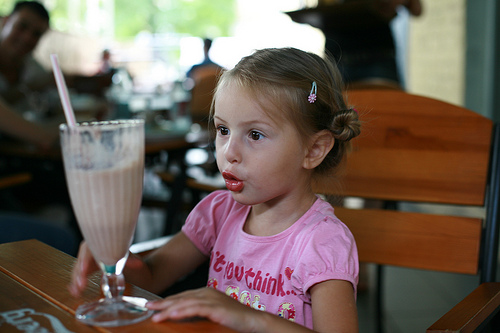

In [24]:
IPython.display.Image(filename=test_df['image_name'][950])


In [54]:
def inference_model(image_name,bw = 3,seq_model = rnn_model):
    if_image_name = image_name
    if_image_name_list = [if_image_name]
    if_spatial_feature = spatial_representation(if_image_name_list,show=False)
  
    print(type(if_spatial_feature))
 
    print(if_spatial_feature.shape)

    if_start_token = w2v_model.wv["<start>"]
    print(if_start_token.shape)

    
    
    if_X = {f'if_X{i+1}': np.zeros((1,maxLen+1,emb_dim)) for i in range(bw)}
    
    for i in range(bw):
        if_X[f'if_X{i+1}'][0][0] = if_spatial_feature
        if_X[f'if_X{i+1}'][0][1] = if_start_token
        
    
    

    if_captions = {f'if_predicted_caption{i+1}':"" for i in range(bw)}
    
    for i in range(2,maxLen+1):
        if(i==2):
            print("----------------------------------------------------------------------")
            print(f'current i is {i}')
            print("----------------------------------------------------------------------")
            if_predictions =seq_model.predict(if_X['if_X1'])
            to_put = if_predictions[0][i-1]
            # print(f'what you see {to_put.shape}')
    
            sampled_index = np.argsort(if_predictions[0][i-1])[-bw:][::-1]
         
          
           
            if_indices = {f'h{j+1}_index': sampled_index[j] for j in range(bw)}
            

    
            
            if_words = {f'h{j+1}_word': index_to_word[if_indices[f'h{j+1}_index']] for j in range(bw)}

        
        
            for j in range(bw):
                if_captions[f'if_predicted_caption{j+1}'] = f"{if_captions[f'if_predicted_caption{j+1}']} {if_words[f'h{j+1}_word']}"
                print(if_captions[f'if_predicted_caption{j+1}'])
        
    
            
            if_embeddings = {f'if_word_embedding_h{j+1}':w2v_model.wv[if_words[f'h{j+1}_word']] for j in range(bw)}
        
      
            
            for j in range(bw):
                if_X[f'if_X{j+1}'][0][i] = if_embeddings[f'if_word_embedding_h{j+1}']
                
            
        
 

            rnn_model.reset_states()
            
        else:
            print("----------------------------------------------------------------------")
            print(f'current i is {i}')
            print("----------------------------------------------------------------------")
            
            # if_predictions_1 = rnn_model.predict(if_X1)
            # if_predictions_2 = rnn_model.predict(if_X2)
            # if_predictions_3 = rnn_model.predict(if_X3)
            
            if_pred = {f'if_predictions_{j+1}':seq_model.predict(if_X[f'if_X{j+1}'])  for j in range(bw)}
            
            
            
            sampled_indices = {f'sampled_index_{j+1}':np.argsort(if_pred[f'if_predictions_{j+1}'][0][i-1])[-bw:][::-1]   for j in range(bw) }
            
            if_probabilities = {}
            if_all_indices = {}
            for j in range(bw):
                for k in range(bw):
                    if_probabilities[f'h{k+1}_{j+1}'] = if_pred[f'if_predictions_{j+1}'][0][i-1][sampled_indices[f'sampled_index_{j+1}'][k]]
                    if_all_indices[f'h{k+1}_{j+1}'] = sampled_indices[f'sampled_index_{j+1}'][k]
                    print(f"Probs {f'h{k+1}_{j+1}'} {if_probabilities[f'h{k+1}_{j+1}']}")
                    print(f"Index {f'h{k+1}_{j+1}'} {if_all_indices[f'h{k+1}_{j+1}']}")
            print(f'all probabilities {if_probabilities}')
                    
            
            if_top_bw_probabilities = dict(sorted(if_probabilities.items(), key=lambda x: x[1], reverse=True)[:bw])
           

            print(f'top prob  {if_top_bw_probabilities}')
            # {'h1_1': 0.09946401, 'h1_3': 0.026552789, 'h2_3': 0.026481574}
            top_bw_keys= list(if_top_bw_probabilities.keys())
            print(f'top keys {top_bw_keys}')
            
            if_top_bw_indices = {top_bw_keys[j]:if_all_indices[top_bw_keys[j]]  for j in range(bw)}
            print(f'top indices  {if_top_bw_indices}')
            if_top_bw_word = {top_bw_keys[j]:index_to_word[if_top_bw_indices[top_bw_keys[j]]]   for j in range(bw)}
            print(f'top words  {if_top_bw_word}')
            
            
            #custom sorting of if_top_bw_word
            temp_dict = {}
            for j in range(bw):
                for k in range(bw):
                   idx = f'h{k+1}_{j+1}'
                   if idx in top_bw_keys:
                       temp_dict[f'h{k+1}_{j+1}'] = if_top_bw_word[f'h{k+1}_{j+1}']
        
            if_top_bw_word = temp_dict
            print(f'sorted top word  {temp_dict}')
            
            if_top_bw_word_vector = {top_bw_keys[j]:w2v_model.wv[if_top_bw_word[top_bw_keys[j]]]  for j in range(bw)}
            print(f'sorted word vector {if_top_bw_word_vector[top_bw_keys[0]].shape}')

                            
            
                
            flag0 = 0
            for j in range(bw):
                for k in range(bw):
                    idx = f'h{k+1}_{j+1}'
                    if idx in top_bw_keys:
                        if_captions[f'if_predicted_caption{flag0+1}'] = if_captions[f'if_predicted_caption{j+1}']
                        flag0 = flag0 + 1
            
            flag00 = 0
            for j in range(bw):
                for k in range(bw):
                    idx = f'h{k+1}_{j+1}'
                    if idx in top_bw_keys:
                        if_captions[f'if_predicted_caption{flag00+1}'] = f"{if_captions[f'if_predicted_caption{flag00+1}']} {if_top_bw_word[idx]}"
                        print(if_captions[f'if_predicted_caption{flag00+1}'])
                        flag00 = flag00 + 1

                        
                
            #use to customize input data with respect to the top predictions
            flag1 = 0
            for j in range(bw):
                
                for k in range(bw):
                    idx = f'h{k+1}_{j+1}'
                    if idx in top_bw_keys :
                        
                        if_X[f'if_X{flag1+1}'] = if_X[f'if_X{j+1}']
                        flag1 = flag1 + 1
                        
            #assign the word vector in input_data
            flag2 = 0
            for j in range(bw):
                for k in range(bw):
                    idx = f'h{k+1}_{j+1}'
                    if idx in top_bw_keys:
                        if_X[f'if_X{flag2+1}'][0][i] = if_top_bw_word_vector[idx]
                        flag2 = flag2 + 1
            rnn_model.reset_states()
    return if_captions
                        
                    

                    
  

In [55]:
captions_dict = inference_model(train_df['image_name'][1000],bw = 5)

img
step 1 done
step 2 done
step 3 done
img data shape is (1, 224, 224, 3)
1/1 [==============================] - 0s 82ms/step
<class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 512)
(512,)
----------------------------------------------------------------------
current i is 2
----------------------------------------------------------------------
1/1 [==============================] - 0s 25ms/step
 "a
 man
 "two
 hiker
 "the
----------------------------------------------------------------------
current i is 3
----------------------------------------------------------------------
1/1 [==============================] - 0s 30ms/step
Probs h1_1 0.05338359624147415
Index h1_1 46
Probs h2_1 0.019952865317463875
Index h2_1 8
Probs h3_1 0.015710964798927307
Index h3_1 10
Probs h4_1 0.01434346567839384
Index h4_1 133
Probs h5_1 0.014024890027940273
Index h5_1 483
Probs h1_2 0.023891760036349297
Index h1_2 1038
Probs h2_2 0.022351272404193878
Index h2_2 8
Probs h3_2 0.012719834223389626
Ind

In [53]:
for idx,caption in captions_dict.items():
    print(idx,caption)
    

if_predicted_caption1  "a "a "a "a "a "a "a "a "a "a "a "a "a "a "a "a "a "a "a "a "a "a "a "a "a "a "a
if_predicted_caption2  "the "a "a man <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end>
if_predicted_caption3  "the "a "a <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end>
if_predicted_caption4  "the "a man man <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end>
if_predicted_caption5  "the "a man <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end>


In [42]:
train_df['comment'][1000]

'<start> black and brown dog laying on white shaggy carpet  <end>'

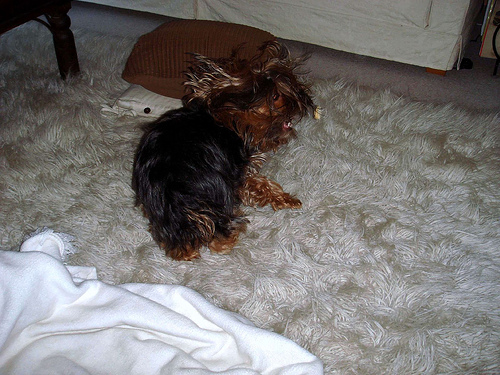

In [43]:
IPython.display.Image(filename=train_df['image_name'][1000])
